[딥러닝을 이용한 자연어처리 입문](https://wikidocs.net/24996)에서 15. RNN을 이용한 인코더-디코더 중 (1) seq2seq 내용 요약
(참고 : [케라스의 함수형 API](https://wikidocs.net/38861))

# 1. Sequence-to-Sequence

시퀀스-투-시퀀스(Sequence-to-Sequence)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 모델
- 입력 시퀀스 : raw text
- 출력 시퀀스 : summary text

seq2seq는 크게 두 개로 구성된 아키텍처(인코더, 디코더)로 구성됨
- 인코더 : 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 context vector라고 함. 입력 문장의 정보가 하나의 context vector로 모두 압축되면 인코더는 context vector를 디코더로 전송
- 디코더 : context vector를 받아서 번역된 단어를 한 개씩 순차적으로 출력
- context vector : 여기서는 4의 사이즈지만 현업에서는 수백 이상의 차원으로 표현
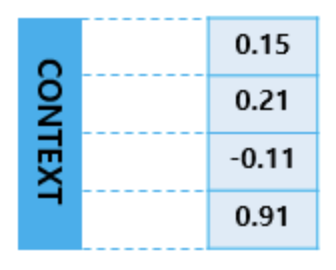

- 인코더 아키텍처와 디코더 아키텍처의 내부는 사실 2개의 RNN 아키텍처임
- 입력 문장을 받는 RNN 셀을 인코더라고 하고, 출력 문장을 출력하는 RNN 셀을 디코더라고 함
- 더 좋은 성능을 위해 LSTM 셀 또는 GRU 셀들로 구성됨

### 테스트 과정
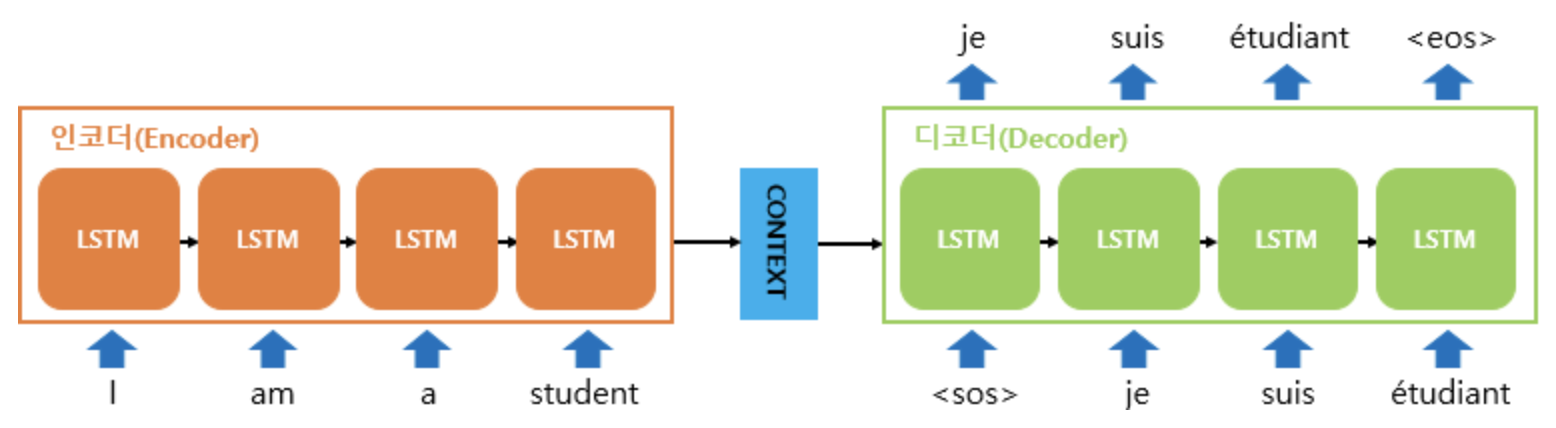
- 인코더를 자세히 보면, 입력 문장은 <b>단어 토큰화</b>를 통해서 단어 단위로 쪼개지고 단어 토큰 각각은 <b>RNN 셀의 각 시점의 입력</b>이 됨
- 인코더 RNN 셀은 모든 단어를 입력받은 뒤 <b>인코더 RNN 셀의 마지막 시점의 은닉 상태</b>를 디코더 RNN 셀로 넘겨주는데 이를 <b>context vector</b>라고 함. context vector는 <b>디코더 RNN 셀의 첫번째 은닉 상태</b>로 사용됨
---
- 디코더는 기본적으로 RNNLM(RNN Language Model)
- 아래는 <b>테스트 과정</b>동안의 이야기
    - 디코더는 초기 입력으로 문장의 시작을 의미하는 심볼 \<sos\>가 들어감. 디코더는 \<sos\>가 입력되면, 다음에 등장할 확률이 높은 단어를 예측함. 위의 사진을 보면, 첫번째 시점(time step)의 디코더 RNN 셀은 다음에 등장할 단어로 je를 예측하였음. 첫번째 시점의 디코더 RNN 셀은 예측된 단어 je를 다음 시점의 RNN 셀의 입력으로 입력함.
    - 그리고 두번째 시점의 디코더 RNN 셀은 입력된 단어 je로부터 다시 다음에 올 단어인 suis를 예측하고, 또 다시 이것을 다음 시점의 RNN 셀의 입력으로 보냄
    - 디코더는 이런 식으로 기본적으로 다음에 올 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복함
    - 이 행위는 문장의 끝을 의미하는 심볼인 \<eos\>가 다음 단어로 예측될 때까지 반복됨

---
### 훈련 과정
- seq2seq는 훈련 과정과 테스트 과정(또는 실제 번역기를 사람이 쓸 때)의 작동 방식이 조금 다름
- 훈련 과정에서는 디코더에게 인코더가 보낸 context vector와 실제 정답인 상황인 \<sos\>je suis etudiant를 입력받았을 때 je suis etudiant\<eos\>가 나와야 된다고 정답을 알려주면서 훈련함<em>(교사 강요(teacher forcing) 개념은 뒤에서 다시)</em>
- 반면 테스트 과정에서는 앞서 설명한 과정과 같이 디코더는 오직 context vector와 \<sos\>만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복함.
- 아래 그림은 <b>입, 출력에 쓰이는 단어 토큰들이 있는 부분</b>
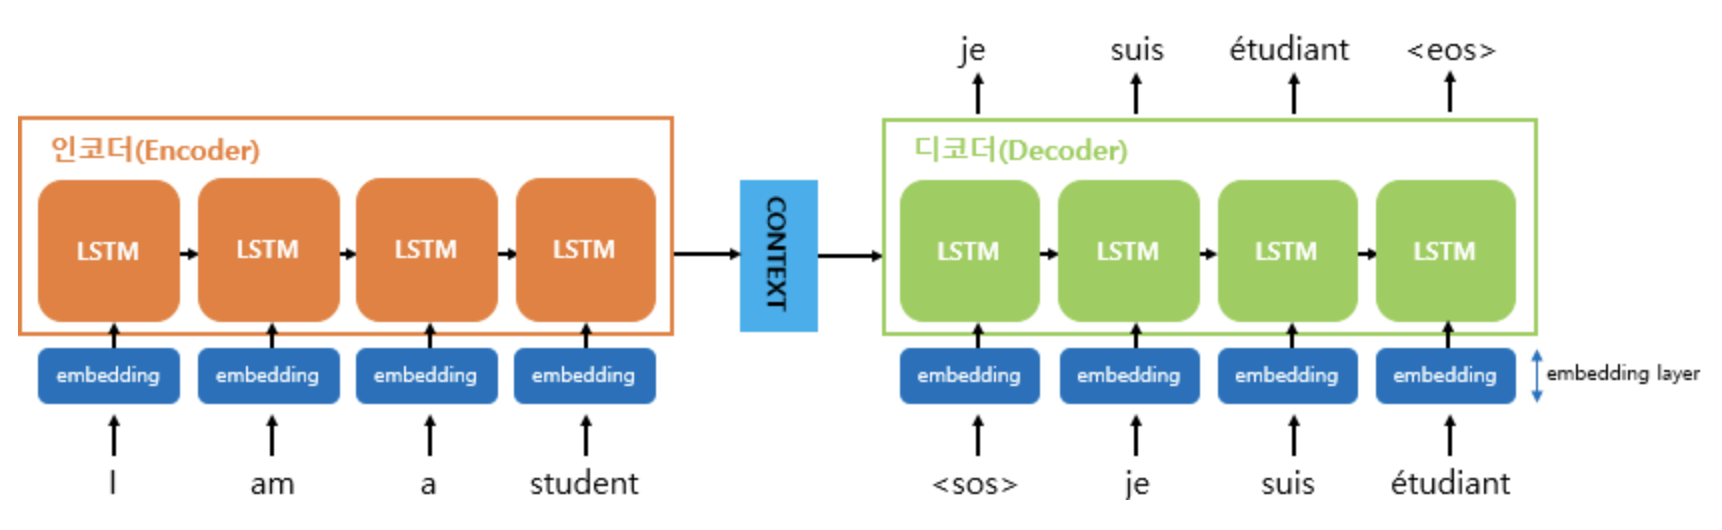


- seq2seq에서 사용되는 모든 단어들은 Word Embedding을 통해 표현된 Embedding vector
- 위 그림을 보면 알 수 있듯이, <b>모든 단어에 대해 임베딩 과정</b>을 거치게 하는 단계 : embedding layer
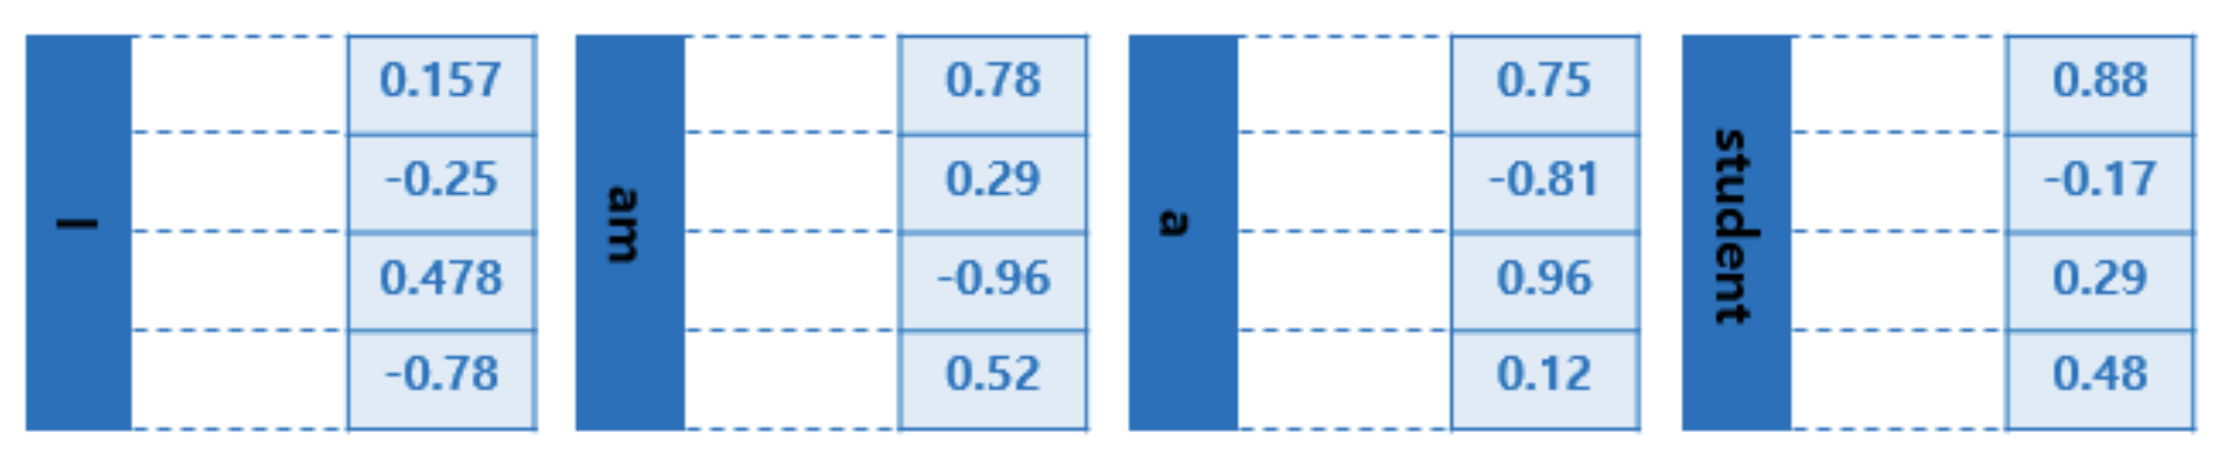
- 위 그림은 I, am, a, student 단어들에 대한 Embedding vector(여기서 차원 수는 4지만 실제론 수백 개의 차원이 될 수 있음)

#### RNN Cell
<img width="50%" height="50%" alt="RNN_Cell" src="https://user-images.githubusercontent.com/54230911/136575916-5c134eee-b89a-4869-a9c9-f09b32e70af8.png">

- 하나의 RNN 셀은 각각의 시점(time step)마다 2개의 입력을 받음
- 현재 시점(time step)을 t라고 할 때, RNN 셀은 t-1에서의 은닉 상태와 t에서의 입력 벡터를 <b>입력</b>으로 받고, t에서의 은닉 상태를 <b>출력</b>함
- 이 때 t에서의 은닉 상태는, 바로 위에 또 다른 은닉층이나 출력층이 존재할 경우에는 위의 층으로 보내거나 필요없으면 값을 무시할 수 있음
- 그리고 RNN 셀은 다음 시점에 해당하는 t+1의 RNN 셀의 입력으로 현재 t에서의 은닉 상태를 입력으로 보냄


- 현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의 <b>모든 은닉 상태의 값들의 영향을 누적</b>해서 받아온 값이라고 볼 수 있음. 따라서 context vector가 인코더에서의 마지막 RNN 셀의 은닉 상태값을 말한다는 의미는 <b>입력 문장의 모든 단어 토큰들의 정보를 요악</b>해서 담고 있다는 것


- 디코더의 첫번째 RNN 셀은 첫번째 은닉 상태값으로 context vector를 사용하고, 현재 t에서의 입력값인 \<sos\>로부터 다음에 등장할 단어를 예측함
- 그렇게 예측된 단어는 다음 시점인 t+1 RNN에서의 입력값이 되고, 이 t+1에서의 RNN 또한 이 입력값과 t에서의 은닉 상태를 <b>입력</b>으로 받아 t+1에서의 출력 벡터(다음 단어)를 예측하게 됨

#### 디코더 예측

<img width="40%" height="40%" alt="decoder_predict" src="https://user-images.githubusercontent.com/54230911/136576072-5e45e908-287f-44b8-959e-3b0a10901bd8.png">

- 출력 단어로 나올 수 있는 다양한 단어들 중 하나의 단어를 어떻게 골라서 예측할까?
- 디코더에서 각 시점(time step)의 RNN 셀에서 출력 벡터가 나오면, 해당 벡터는 <b>소프트맥스 함수</b>를 통해 출력 시퀀스의 <b>각 단어별 확률값</b>을 반환하고, 디코더는 <b>출력 단어를 결정</b>
---
### 정리
- seq2seq는 어떻게 구현하느냐에 따라 충분히 더 복잡해질 수 있음
- 위의 방식처럼 context vector를 디코더의 초기 은닉 상태로만 사용할 수도 있고, 
- 더 나아가 context vector를 <b>디코더가 단어를 예측하는 매 시점마다 하나의 입력으로</b> 사용할 수도 있으며, 
- 더 나아가 <b>Attention 메커니즘</b>을 통해 더욱 <b>문맥을 반영할 수 있는 context vector를 구하여 매 시점마다 하나의 입력으로 사용</b>할 수도 있음